In [71]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [72]:
%matplotlib inline

In [73]:
from relaxed.plot_defaults import *

In [74]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split



In [75]:
from relaxed.analysis import setup, get_quantiles, gaussian_conditional, get_am, get_an_from_am, get_lam, get_ma

# Data

In [76]:
# catalog
hcat, indices, scales = setup('m11', path='../../output')

# get ma 
ma = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../output')

Text(0.5, 0, '\\rm index')

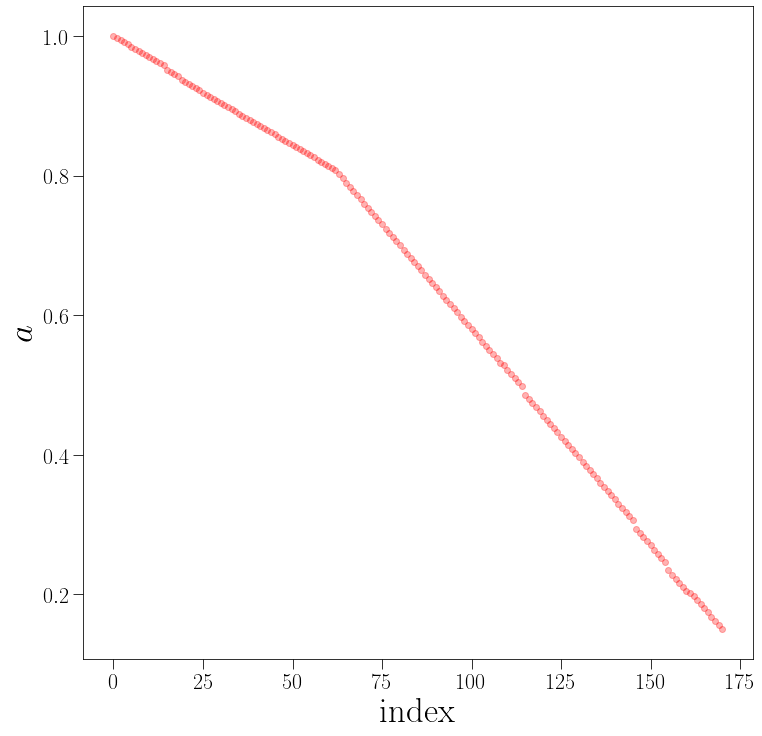

In [80]:
plt.figure(figsize=(12, 12))
plt.plot(scales, 'ro', alpha=0.3)
plt.ylabel(r"$a$", size=35)
plt.xlabel(r"\rm index", size=35)
# notice change in spacing below

# Calculate gradients

In [84]:
import findiff
def get_gradient(f, x, k=1, acc=2):
    # f is an array with samples from a function
    # x is the points where f is evaluated, x is assumed to be a uniform grid (linear spacing). 
    # k controls the step size. 
    # acc is the accuracy at which to take the derivative.
    assert len(f) >= 2*k and len(f.shape)==1
    coeff_table = findiff.coefficients(deriv=1, acc=acc)
    grad = [] 
    
    for i in range(len(f)):
        if i - k*(acc//2) < 0: 
            mode = 'forward'
            hx = x[i+1] - x[i] # accretion rate changes spacing a little bit at some scale.
        elif i - k*(acc//2) >=0 and i+k*(acc//2) < len(f):
            mode = 'center'
            hx = x[i+1] - x[i]
        else: 
            mode = 'backward'
            hx = x[i] - x[i-1]
        
        coeffs = coeff_table[mode]['coefficients'] #coefficients are indepenent of step size. 
        offsets = coeff_table[mode]['offsets']*k + i
        
        assert np.all((offsets < len(f))&(offsets >= 0))
        
        deriv = np.sum(f[offsets]*coeffs) / (hx*k)
        grad.append(deriv)
        
    return np.array(grad)

In [83]:
findiff.coefficients(deriv=1, acc=6)

{'center': {'coefficients': array([-1.66666667e-02,  1.50000000e-01, -7.50000000e-01, -2.35624724e-16,
          7.50000000e-01, -1.50000000e-01,  1.66666667e-02]),
  'offsets': array([-3, -2, -1,  0,  1,  2,  3]),
  'accuracy': 6},
 'forward': {'coefficients': array([-2.45      ,  6.        , -7.5       ,  6.66666667, -3.75      ,
          1.2       , -0.16666667]),
  'offsets': array([0, 1, 2, 3, 4, 5, 6]),
  'accuracy': 6},
 'backward': {'coefficients': array([ 0.16666667, -1.2       ,  3.75      , -6.66666667,  7.5       ,
         -6.        ,  2.45      ]),
  'offsets': array([-6, -5, -4, -3, -2, -1,  0]),
  'accuracy': 6}}

In [87]:
get_gradient(np.log(ma[0, :]), scales, k=1, acc=6)

array([-1.58861303e+00,  1.04841579e+00,  2.07184885e+00, -8.72337259e-02,
       -3.72153562e-01, -2.62483406e+00, -1.13587282e+00, -7.37052792e-02,
       -1.34044779e+00, -7.74226575e-01, -1.85404233e-01,  3.06512889e-01,
       -4.84552928e-01, -9.24899903e-01, -5.73640102e-02, -1.48166289e+00,
       -7.85998260e-01,  9.42874032e-01, -4.09324730e-01, -5.22468405e-01,
       -3.41251587e-01, -1.36309634e+00, -1.71223145e+00, -1.28111752e+00,
        5.24517118e-02, -3.08717642e-01, -7.56609451e-01,  1.16976344e+00,
       -5.29653613e-01, -2.05148077e+00, -1.68971545e+00, -2.60152124e+00,
       -1.79333803e+00, -2.04649783e+00, -1.50233352e+00, -2.35260750e-01,
       -2.12838457e+00, -1.76919481e+00, -9.23393742e-01, -2.60217578e+00,
       -1.27024843e+00, -1.40566384e+00, -1.84957245e+00, -1.54498664e+00,
       -2.66383271e+00, -1.40105320e+00, -3.89781260e-01, -1.16494270e+00,
       -1.08310093e+00, -8.04915138e-01, -7.73408370e-01, -1.70871857e+00,
       -3.81546424e+00, -

## numpy

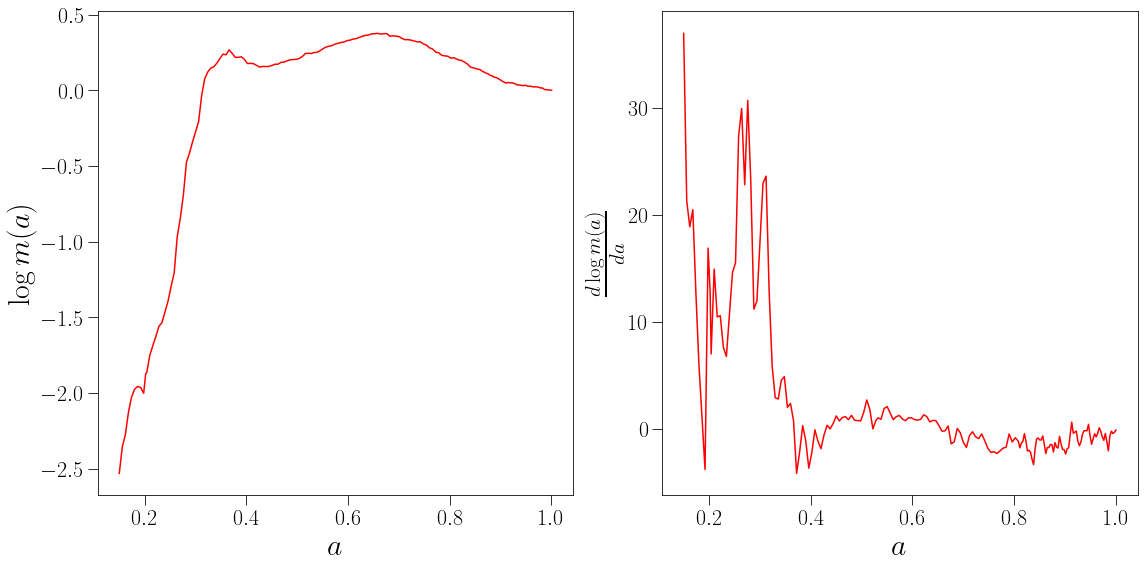

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
idx = 0
x = scales
grad = np.gradient(np.log(ma[idx, :]), x, edge_order=2)
ax1.plot(x, np.log(ma[idx, :]), 'r-')
ax2.plot(x, grad, 'r-')

ax1.set_xlabel(r"$a$", size=30)
ax2.set_xlabel(r"$a$", size=30)

ax1.set_ylabel(r"$\log m(a)$", size=30)
ax2.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
plt.tight_layout()

## vary k 

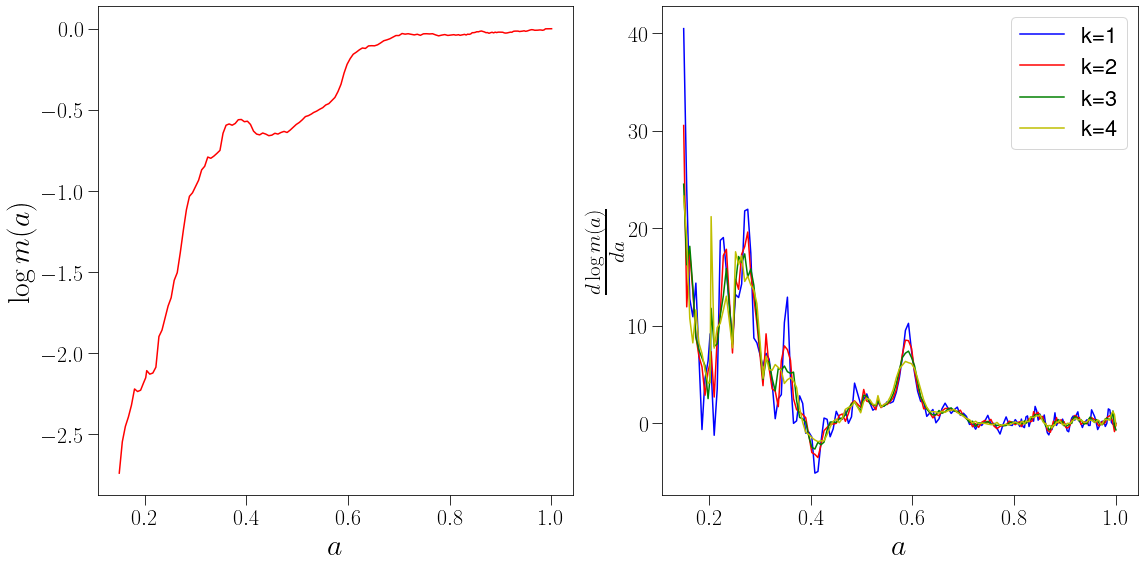

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
idx = np.random.randint(len(ma))
x = scales
ks = np.arange(1, 5)
colors = ['b', 'r', 'g', 'y', 'm']
ax1.plot(x, np.log(ma[idx, :]), 'r-')
for c,k in zip(colors, ks): 
    grad = get_gradient(np.log(ma[idx, :]), x, k=k)
    ax2.plot(x, grad, f'{c}-', label=f"k={k}")

ax1.set_xlabel(r"$a$", size=30)
ax2.set_xlabel(r"$a$", size=30)

ax1.set_ylabel(r"$\log m(a)$", size=30)
ax2.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
ax2.legend(loc='best')
plt.tight_layout()

## Fix k, vary accuracy

In [89]:
idx = np.random.randint(len(ma))

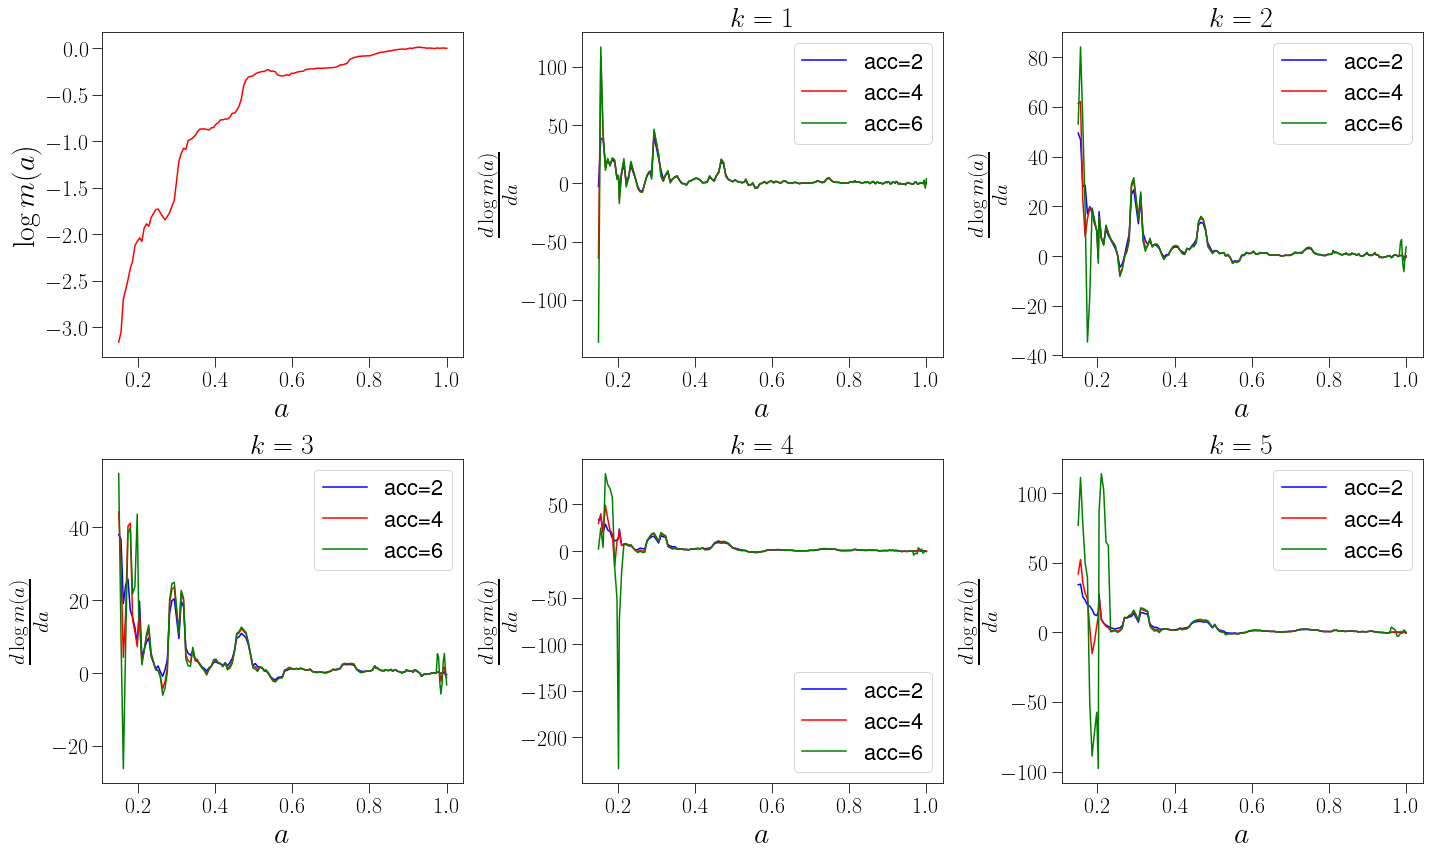

In [108]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()
ax1 = axes[0]
axs = axes[1:]
x = scales
ks = [1,2,3,4,5]
accs = [2, 4, 6]
colors = ['b', 'r', 'g']
ax1.plot(x, np.log(ma[idx, :]), 'r-')
for k, ax in zip(ks, axs): 
    for c, acc in zip(colors, accs): 
        grad = get_gradient(np.log(ma[idx, :]), x, k=k, acc=acc)
        ax.plot(x, grad, f'{c}-', label=f"acc={acc}")
    ax.set_xlabel(r"$a$", size=30)
    ax.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
    ax.legend(loc='best')
    ax.set_title(fr"$k={k}$")
    
ax1.set_xlabel(r"$a$", size=30)
ax1.set_ylabel(r"$\log m(a)$", size=30)
plt.tight_layout()

Text(0.5, 1.0, '$k=2$')

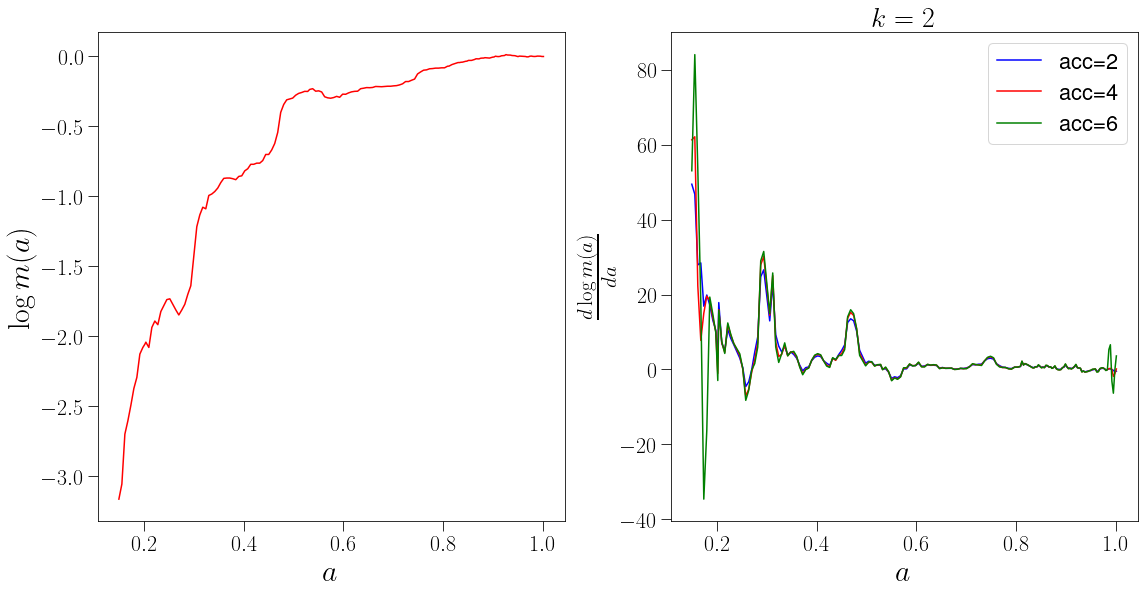

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
x = scales
k = 2
accs = [2, 4, 6]
colors = ['b', 'r', 'g']
ax1.plot(x, np.log(ma[idx, :]), 'r-')
for c,acc in zip(colors, accs): 
    grad = get_gradient(np.log(ma[idx, :]), x, k=k, acc=acc)
    ax2.plot(x, grad, f'{c}-', label=f"acc={acc}")

ax1.set_xlabel(r"$a$", size=30)
ax2.set_xlabel(r"$a$", size=30)

ax1.set_ylabel(r"$\log m(a)$", size=30)
ax2.set_ylabel(r"$\frac{d\log m(a)}{da}$", size=30)
ax2.legend(loc='best')
plt.tight_layout()
ax2.set_title(fr"$k={k}$")